In [1]:
from datetime import datetime
import pandas as pd 
import pandas_profiling
import numpy as np 
import seaborn as sns
sns.set_style("darkgrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# -------------------------------------------------------------------
import xgboost as xgb
from surprise import Reader , Dataset 
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV  

In [2]:
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

In [3]:
my_data = pd.read_csv('./MoviesOnStreamingPlatforms_updated.csv.zip')

In [4]:
my_data.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [5]:
# Shaping the data 

my_data.shape

(16744, 17)

In [6]:
my_data.columns


Index(['Unnamed: 0', 'ID', 'Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes',
       'Netflix', 'Hulu', 'Prime Video', 'Disney+', 'Type', 'Directors',
       'Genres', 'Country', 'Language', 'Runtime'],
      dtype='object')

#  generating report

In [7]:
pandas_profiling.ProfileReport(my_data)

In [8]:
# Seperate genre column in dataset 
seperate_gen = my_data['Genres'].str.get_dummies(',')

In [9]:
# concat two dataframes
my_data = pd.concat([my_data, seperate_gen], axis=1, sort = False)

In [10]:
# seperate movie platform for better understanding 

netflix_movies = my_data.loc[my_data['Netflix']==1]

hulu_movies = my_data.loc[my_data['Hulu']==1]

prime_video_movies = my_data.loc[my_data['Prime Video']==1]

Disney_plus = my_data.loc[my_data['Disney+'] ==1]

In [11]:
# dropping columns of other movies watching platforms and unnecessary columns
netflix_movies = netflix_movies.drop(['Hulu', 'Prime Video', 'Disney+', 'Type', 'Unnamed: 0','Genres'], axis = 1)
hulu_movies = hulu_movies.drop(['Netflix', 'Prime Video', 'Disney+', 'Type', 'Unnamed: 0','Genres'], axis = 1)
prime_video_movies = prime_video_movies.drop(['Hulu', 'Netflix', 'Disney+', 'Type', 'Unnamed: 0','Genres'], axis = 1)
Disney_plus = Disney_plus.drop(['Hulu', 'Prime Video', 'Netflix', 'Type', 'Unnamed: 0','Genres'], axis = 1)

In [12]:
Disney_plus.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Disney+,Directors,Country,Language,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
95,96,Saving Mr. Banks,2013,13+,7.5,79%,1,John Lee Hancock,"United States,United Kingdom,Australia",English,...,0,0,0,0,0,0,0,0,0,0
103,104,Amy,2015,18+,7.8,95%,1,NaN,United States,English,...,0,0,0,0,0,0,0,0,0,0
122,123,Bolt,2008,7+,6.8,89%,1,"Byron Howard,Chris Williams",United States,English,...,0,0,0,0,0,0,0,0,0,0
125,126,The Princess and the Frog,2009,all,7.1,85%,1,"Ron Clements,John Musker",United States,"English,French",...,0,0,1,0,0,0,0,0,0,0
150,151,Miracle,2004,7+,7.5,81%,1,Gavin O'Connor,"Canada,United States",English,...,0,0,0,0,0,1,0,0,0,0


In [13]:
Disney_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 95 to 16743
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               564 non-null    int64  
 1   Title            564 non-null    object 
 2   Year             564 non-null    int64  
 3   Age              500 non-null    object 
 4   IMDb             563 non-null    float64
 5   Rotten Tomatoes  345 non-null    object 
 6   Disney+          564 non-null    int64  
 7   Directors        555 non-null    object 
 8   Country          561 non-null    object 
 9   Language         562 non-null    object 
 10  Runtime          555 non-null    float64
 11  Action           564 non-null    int64  
 12  Adventure        564 non-null    int64  
 13  Animation        564 non-null    int64  
 14  Biography        564 non-null    int64  
 15  Comedy           564 non-null    int64  
 16  Crime            564 non-null    int64  
 17  Documentary  

In [14]:
idx_netflex= netflix_movies.index
total_netflix_movies =  len(idx_netflex)

idx_hulu = hulu_movies.index
total_hulu_movies = len(idx_hulu)

idx_prime = prime_video_movies.index
total_prime_movies = len(idx_prime)

idx_disney = Disney_plus.index
total_disney_movies = len(idx_disney)




NameError: name 'axl' is not defined

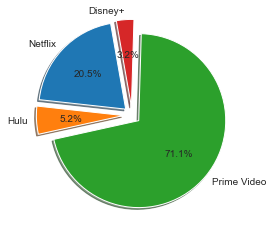

In [16]:
#Pie chart showing platform with most number of the movies

labels = 'Netflix', 'Hulu', 'Prime Video' , 'Disney+'
sizes = [total_netflix_movies, total_hulu_movies , total_prime_movies,total_disney_movies]
explode = (0.1, 0.1 , 0.1, 0.1)
fig1 , ax1 = plt.subplots()

ax1.pie (sizes,
         explode = explode,
         labels = labels,
         autopct = '%1.1f%%', 
         shadow = True,
         startangle = 100
        )

axl.axis ('equal')
plt.show()

In [17]:
netflix_movies['time'] = netflix_movies['Runtime']
netflix_movies['screenplay'] = netflix_movies['time']/60

hulu_movies['time'] = hulu_movies['Runtime']
hulu_movies['screenplay'] = hulu_movies['time'] /60

prime_video_movies['time'] = prime_video_movies['Runtime']
prime_video_movies['screenplay'] = prime_video_movies['time']/60

Disney_plus['time'] = Disney_plus['Runtime']
Disney_plus['screenplay'] = Disney_plus['time'] /60

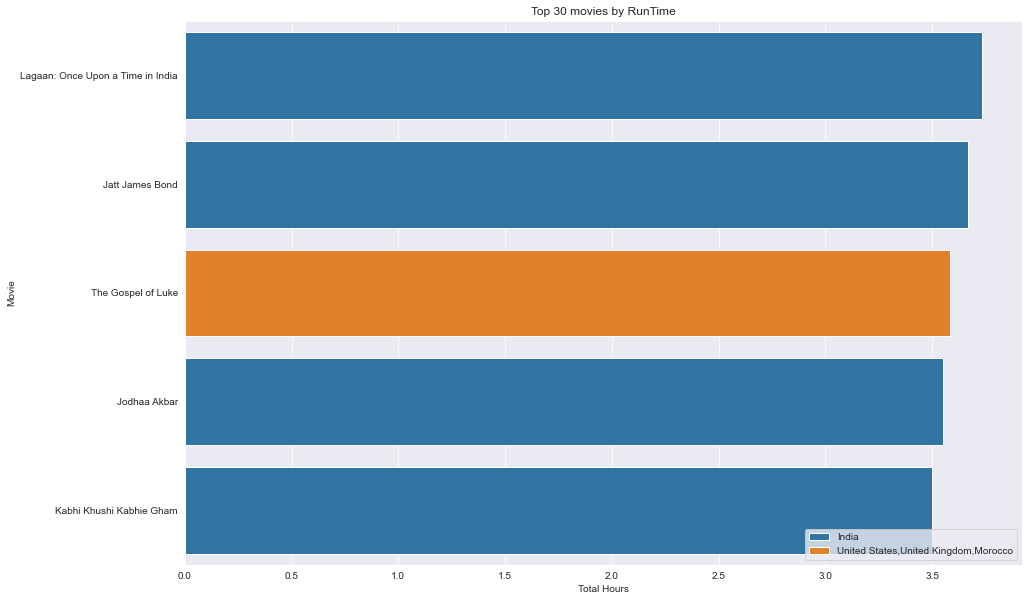

In [18]:
# Looking at the top 30 runtime movies on netflix
top_30 =  netflix_movies.sort_values(by = 'screenplay', ascending = False).head()

plt.figure(figsize=(15,10))
sns.barplot(data = top_30, y='Title', x='screenplay', hue = 'Country', dodge = False)
plt.legend(loc = 'lower right')
plt.xlabel('Total Hours')
plt.ylabel('Movie')
plt.title('Top 30 movies by RunTime')

plt.show()


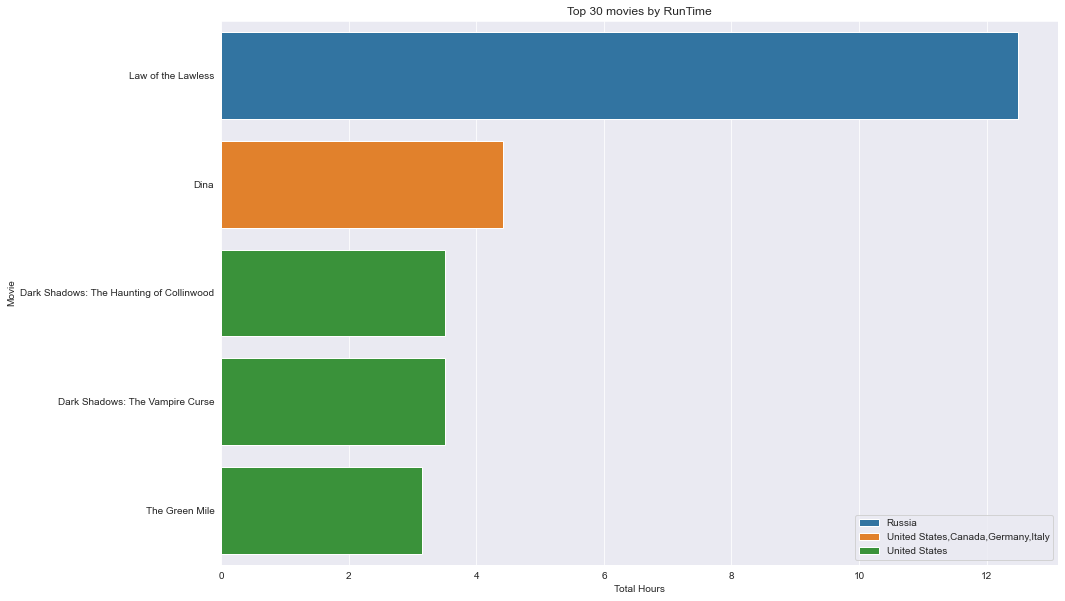

In [19]:
# Looking at the top 30 runtime movies on hulu
top_30 =  hulu_movies.sort_values(by = 'screenplay', ascending = False).head()

plt.figure(figsize=(15,10))
sns.barplot(data = top_30, y='Title', x='screenplay', hue = 'Country', dodge = False)
plt.legend(loc = 'lower right')
plt.xlabel('Total Hours')
plt.ylabel('Movie')
plt.title('Top 30 movies by RunTime')

plt.show()


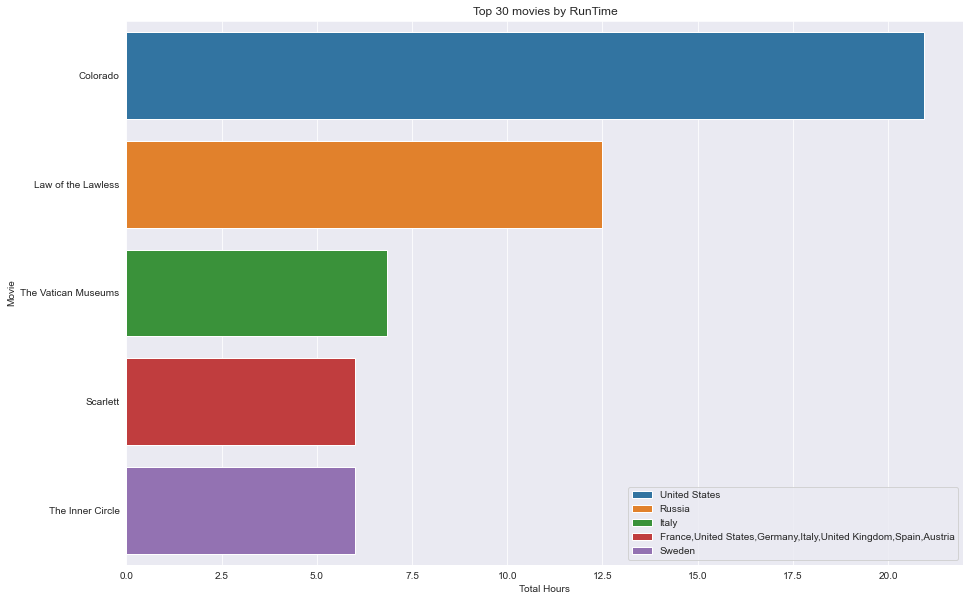

In [20]:
# Looking at the top 30 runtime movies on Amazon Prime Video

top_30 =  prime_video_movies.sort_values(by = 'screenplay', ascending = False).head()

plt.figure(figsize=(15,10))
sns.barplot(data = top_30, y='Title', x='screenplay', hue = 'Country', dodge = False)
plt.legend(loc = 'lower right')
plt.xlabel('Total Hours')
plt.ylabel('Movie')
plt.title('Top 30 movies by RunTime')

plt.show()




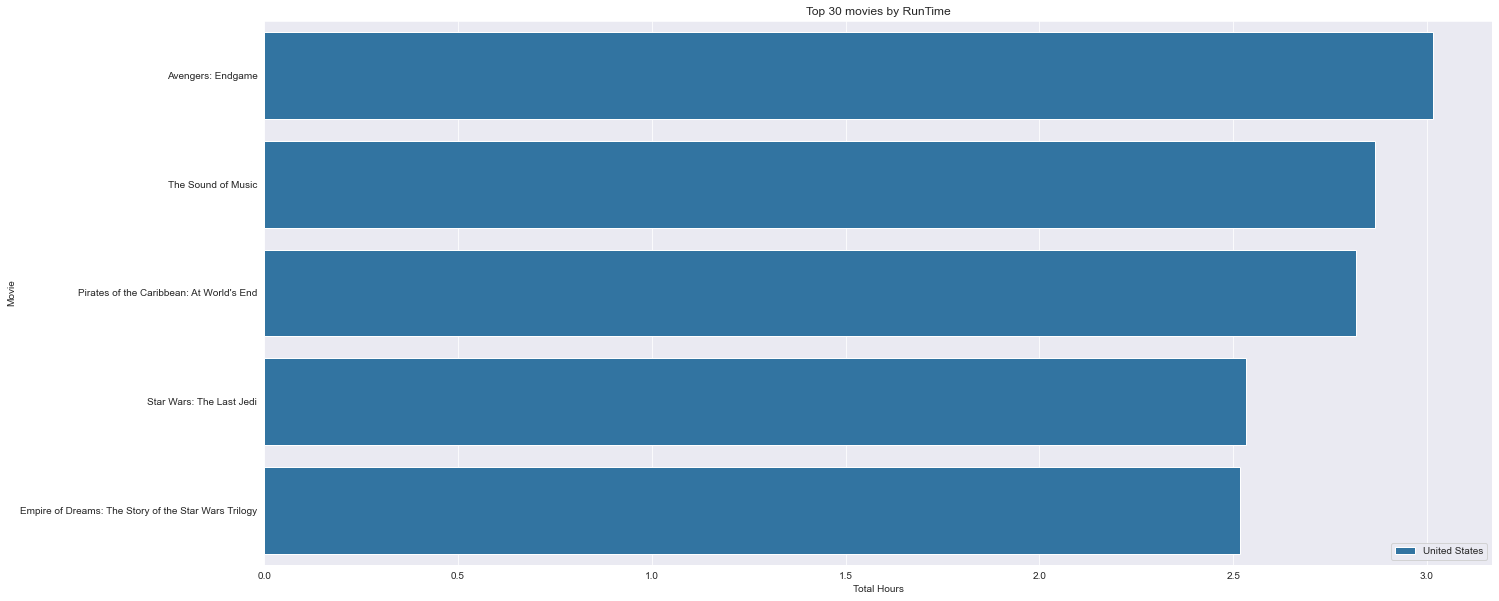

In [21]:
# Looking at the top 30 runtime movies on Disney+
top_30 =  Disney_plus.sort_values(by = 'screenplay', ascending = False).head()

plt.figure(figsize=(22,10))
sns.barplot(data = top_30, y='Title', x='screenplay', hue = 'Country', dodge = False)
plt.legend(loc = 'lower right')
plt.xlabel('Total Hours')
plt.ylabel('Movie')
plt.title('Top 30 movies by RunTime')

plt.show()


In [22]:
# streaming platform with most movies above 8+ rating (IMDb)

rate_mov_netflix = netflix_movies['IMDb'] > 0
print("Total Movies on Netflix with more 8+ ratings on IMDb:"), rate_mov_netflix.sum()

Total Movies on Netflix with more 8+ ratings on IMDb:


(None, 3442)

In [23]:
rate_mov_hulu = hulu_movies['IMDb'] >0 
print("Total Movies on Hulu with more 8+ ratings on IMDb:"), rate_mov_hulu.sum()

Total Movies on Hulu with more 8+ ratings on IMDb:


(None, 891)

In [24]:
rate_mov_prime = prime_video_movies['IMDb'] >0
print("Total Movies on Prime with more 8+ ratings on IMDb:"), rate_mov_prime.sum()


Total Movies on Prime with more 8+ ratings on IMDb:


(None, 11905)

In [25]:
rate_mov_disney = Disney_plus['IMDb'] >0 
print("Total Movies on Disney+ with more 8+ ratings on IMDb:"), rate_mov_disney.sum()

Total Movies on Disney+ with more 8+ ratings on IMDb:


(None, 563)

In [26]:
top_rated_movies = [rate_mov_netflix.sum(),
                    rate_mov_hulu.sum(),
                    rate_mov_prime.sum(),
                     rate_mov_disney.sum()]

top_plot =['Netflix' , 'Hulu' , 'Prime Video' , 'Disney']

In [27]:
top_rated_data = pd.DataFrame({
    'platforms' :['Netflix',
                  'Hulu',
                  'Prime Video',
                  'Disney'
                 ],
    'total_mov' : [rate_mov_netflix.sum(),
                  rate_mov_hulu.sum(),
                  rate_mov_prime.sum(),
                  rate_mov_disney.sum()]



})

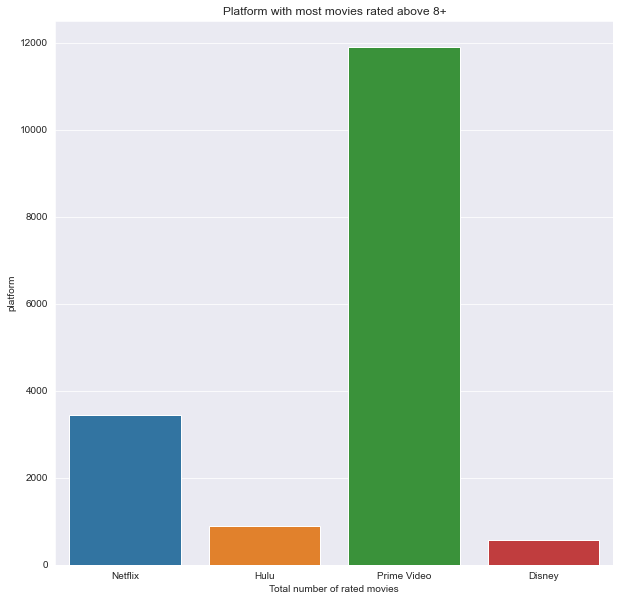

In [28]:
plt.figure(figsize=(10,10))
sns.barplot(data = top_rated_data, 
           x= top_rated_data['platforms'],
           y= top_rated_data['total_mov'])

plt.ylabel('platform')
plt.xlabel('Total number of rated movies')
plt.title('Platform with most movies rated above 8+')
plt.show()


In [29]:
list_gen = my_data['Genres'].str.split(',',expand =True)

In [30]:
list_gen


,0,1,2,3,4,5,6,7,8
0,Action,Adventure,Sci-Fi,Thriller,None,None,None,None,None
1,Action,Sci-Fi,None,None,None,None,None,None,None
2,Action,Adventure,Sci-Fi,None,None,None,None,None,None
3,Adventure,Comedy,Sci-Fi,None,None,None,None,None,None
4,Western,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
16739,Comedy,Family,Fantasy,Horror,None,None,None,None,None
16740,Comedy,Family,Sci-Fi,None,None,None,None,None,None
16741,Documentary,None,None,None,None,None,None,None,None
16742,Documentary,None,None,None,None,None,None,None,None


In [31]:
# covert all elements of dataframe into strings
list_gen = list_gen.applymap(str)

In [32]:
# extracting Genres from my_data(dataframe)

movie_genres = []
for i in range(0,9):
    list_gen[i]
    for j in range(0,16744):
        if (list_gen[i][j] not in movie_genres) and list_gen[i][j] != 'None' and list_gen[i][j] != 'nan':
            movie_genres.append(list_gen[i][j])
        else: 
            pass
        
movie_genres

['Action',
 'Adventure',
 'Western',
 'Animation',
 'Biography',
 'Drama',
 'Crime',
 'Comedy',
 'Documentary',
 'Family',
 'Horror',
 'Thriller',
 'Mystery',
 'Fantasy',
 'Romance',
 'Short',
 'Sci-Fi',
 'Talk-Show',
 'Sport',
 'Reality-TV',
 'Musical',
 'Music',
 'War',
 'News',
 'History',
 'Game-Show',
 'Film-Noir']

No handles with labels found to put in legend.


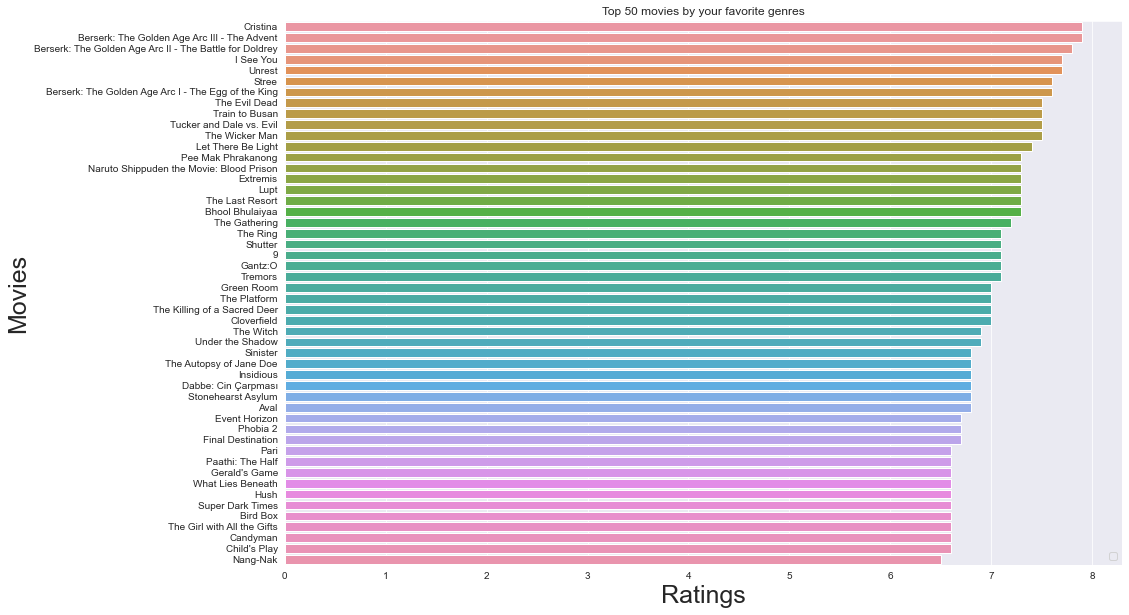

In [33]:
# This function is used to display top rated movies(based on Favorite Genres and platforms)
def top_rated_mov(genre, platform, n_top):
    genre = platform.loc[platform[genre] == 1]
    
    top_50 = genre.sort_values(by = 'IMDb', ascending = False).head(n_top)
    
    
    plt.figure(figsize=(15,10))
    sns.barplot(data= top_50 , y = 'Title', x='IMDb', dodge = False)
    plt.legend(loc = 'lower right')
    plt.xlabel('Ratings', Fontsize = 25)
    plt.ylabel('Movies', Fontsize = 25)
    plt.title('Top 50 movies by your favorite genres')
    plt.show()
    
top_rated_mov('Horror', netflix_movies, 50)

No handles with labels found to put in legend.


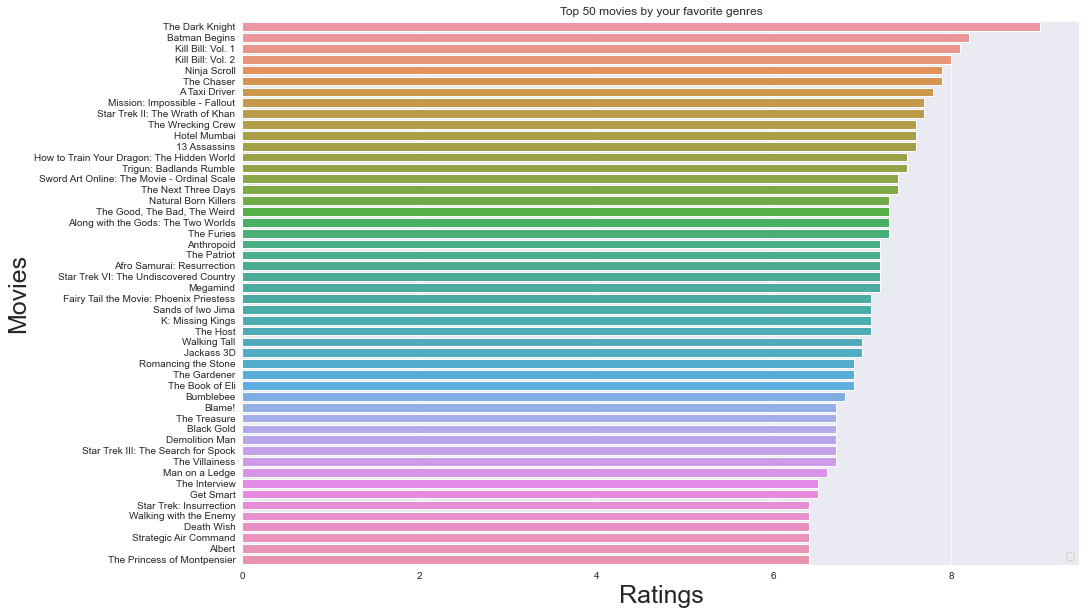

In [34]:
top_rated_mov('Action', hulu_movies, 50)

No handles with labels found to put in legend.


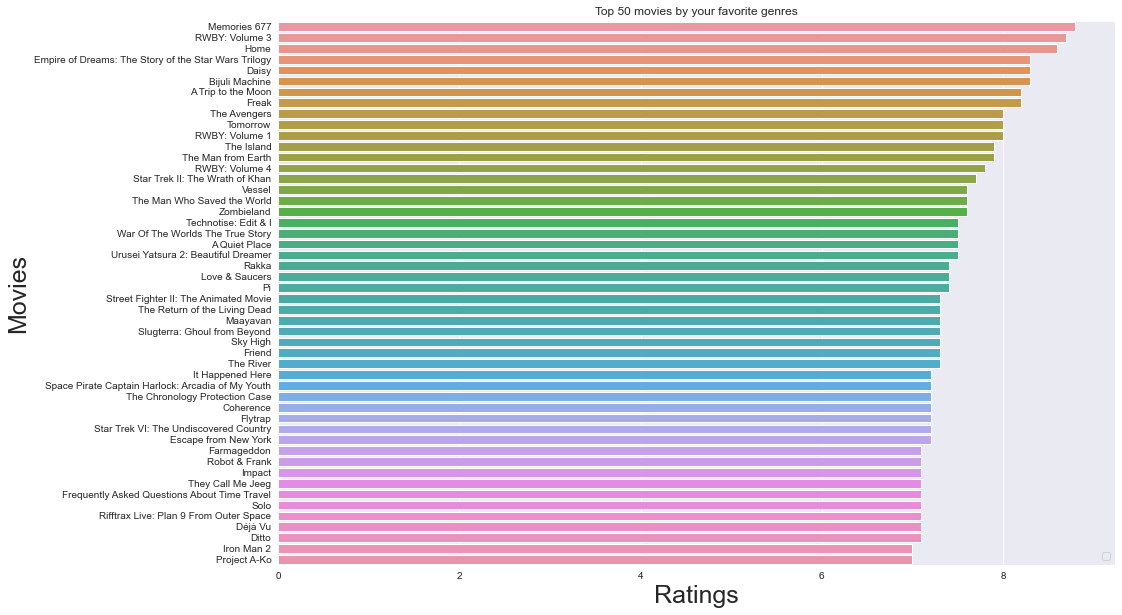

In [35]:
top_rated_mov('Sci-Fi', prime_video_movies, 50)

No handles with labels found to put in legend.


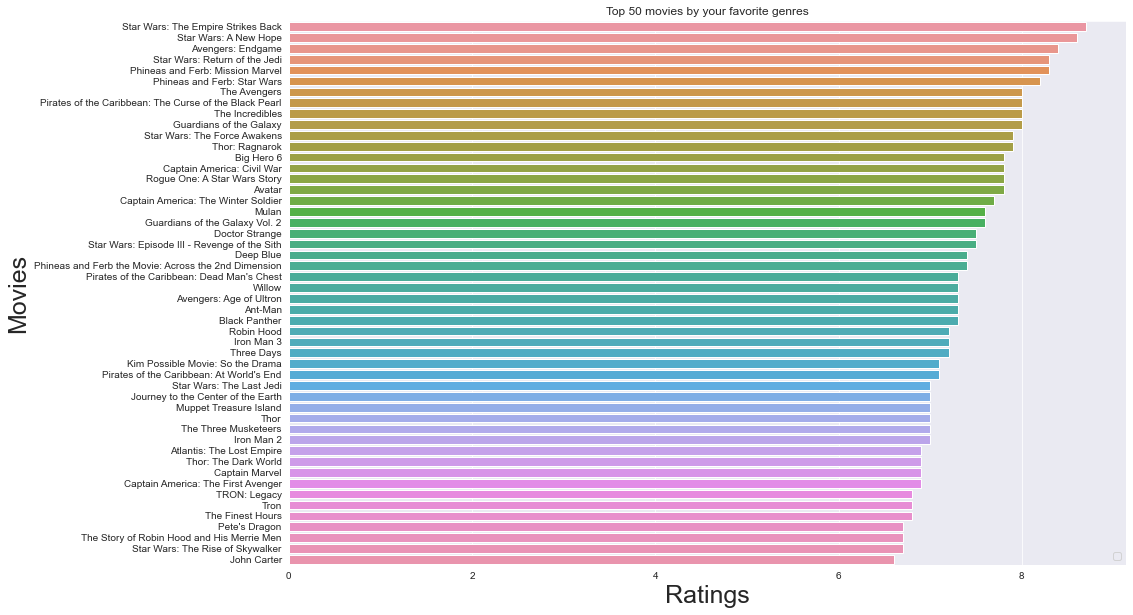

In [36]:
top_rated_mov('Action', Disney_plus, 50)

# Creating Recomendation system for netflix TVshows and Movies !!!!!

In [37]:
netflix_data = pd.read_csv('./netflix-shows/netflix_titles.csv')

In [38]:
netflix_data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [39]:
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [40]:
netflix_data = netflix_data[['title','director','cast','listed_in','description']]
netflix_data.head()

,title,director,cast,listed_in,description
0,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,Jandino: Whatever it Takes,NaN,Jandino Asporaat,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",Kids' TV,"With the help of three human allies, the Autob..."
3,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",Kids' TV,When a prison ship crash unleashes hundreds of...
4,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",Comedies,When nerdy high schooler Dani finally attracts...


In [41]:
# importing required libraries
!pip install rake_nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

In [42]:
# Rake(
#     stopwords=None,
#     punctuations=None,
#     language='english',
#     ranking_metric=<Metric.DEGREE_TO_FREQUENCY_RATIO: 0>,
#     max_length=100000,
#     min_length=1,
# )
# Docstring:      Rapid Automatic Keyword Extraction Algorithm.
# Init docstring:
# Constructor.

# :param stopwords: List of Words to be ignored for keyword extraction.
# :param punctuations: Punctuations to be ignored for keyword extraction.
# :param language: Language to be used for stopwords
# :param max_length: Maximum limit on the number of words in a phrase
#                    (Inclusive. Defaults to 100000)
# :param min_length: Minimum limit on the number of words in a phrase
#                    (Inclusive. Defaults to 1)
# File:           ~/opt/anaconda3/lib/python3.8/site-packages/rake_nltk/rake.py
# Type:           type
# Subclasses:     
rake = Rake()


In [43]:
netflix_data['director'] = netflix_data['director'].fillna(' ')

netflix_data['director'] = netflix_data['director'].astype(str)

netflix_data['cast']  = netflix_data['cast'].fillna(' ')

netflix_data['cast'] = netflix_data['cast'].astype(str)

In [44]:
netflix_data['key_notes'] = ''
for index,row in netflix_data.iterrows():
    plot = row['description']
    
    rake.extract_keywords_from_text(plot)
    keyword_score = rake.get_word_degrees()
    
    genre = ''.join(row['listed_in'].split(',')).lower()
    director = ''.join(row['director'].replace(' ','').split(',')).lower()
    cast = ' '.join(row['cast'].replace(' ','').split(',')).lower()
    keyword_score = ' '.join(list(keyword_score.keys()))
    
    row['key_notes'] = genre + ' ' + ' ' + director + ' ' + cast + ' ' + keyword_score

recommend = netflix_data[['title','key_notes']]
recommend.head()

,title,key_notes
0,Norm of the North: King Sized Adventure,children & family movies comedies richardfinn...
1,Jandino: Whatever it Takes,stand-up comedy jandinoasporaat serenades co...
2,Transformers Prime,kids' tv petercullen sumaleemontano frankwel...
3,Transformers: Robots in Disguise,kids' tv willfriedle darrencriss constancezi...
4,#realityhigh,comedies fernandolebrija nestacooper katewals...


In [45]:
cv = CountVectorizer()
count_mat = cv.fit_transform(recommend['key_notes'])
cosine_similar = cosine_similarity(count_mat,count_mat)
print(cosine_similar)

[[1.         0.         0.         ... 0.0942809  0.03086067 0.03390318]
 [0.         1.         0.04472136 ... 0.         0.         0.        ]
 [0.         0.04472136 1.         ... 0.         0.10141851 0.07427814]
 ...
 [0.0942809  0.         0.         ... 1.         0.         0.        ]
 [0.03086067 0.         0.10141851 ... 0.         1.         0.21971769]
 [0.03390318 0.         0.07427814 ... 0.         0.21971769 1.        ]]


In [48]:
recomen = pd.Series(recommend['title'])
def recommend_movie(name):
    movie = []
    idx = recomen[recomen == name].index[0]
    sort_index = pd.Series(cosine_similar[idx]).sort_values(ascending=False)
    recommendation_5 = sort_index.iloc[1:5]
    
    for rec_mov in recommendation_5.index:
        movie.append(recomen[rec_mov])
        
    return movie

In [ ]:
def recommended_movies_for_you():
    try:
        i = 1
        while(i > 0):
            name = input('Enter name of a movie or tv show:')
            if name.lower() == 'quit':
                break
            else:
                print(recommend_movie(name))
                
    except KeyboardInterrupt:
        print('The movie or Tv Show does not exist/n')
        recommended_movies_for_you()
        
    except IndexError:
        print('The movie or Tv Show does not exist/n')
        recommended_movies_for_you()
        
print('to exit /"quit/"/n')
recommended_movies_for_you()
    

to exit /"quit/"/n
Enter name of a movie or tv show:Transformers Prime
['Transformers: Robots in Disguise', 'You vs. Wild', 'All Hail King Julien: Exiled', 'We Bare Bears']
